In [2]:
# A) Setup: load v2 data/meta + NEW folds (nbhd-tier × price strat) and init MLflow
import os, json, warnings
import numpy as np
import pandas as pd
from pathlib import Path
warnings.filterwarnings("ignore")

import mlflow

# MLflow path - point to root mlruns directory
os.environ["MLFLOW_TRACKING_URI"] = "file:../mlruns"  # Go up one level to root
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("houseprices_xgb")

DATA_DIR = Path("../data/")
PROCESSED_DIR = DATA_DIR / "processed"
ARTIFACTS_DIR = Path("../artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
OOF_DIR = ARTIFACTS_DIR / "oof"; OOF_DIR.mkdir(exist_ok=True)
SUB_DIR = ARTIFACTS_DIR / "submissions"; SUB_DIR.mkdir(exist_ok=True)

# v2 features + meta
df_tr = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v02.csv")
df_te = pd.read_csv(PROCESSED_DIR / "hp_test_feat_v02.csv")
with open(PROCESSED_DIR / "hp_clean_meta_v03.json","r") as f:
    meta = json.load(f)

# NEW folds file (stratified by nbhd tier × price)
folds_df = pd.read_csv(PROCESSED_DIR / "cv_folds_strat_nbhd_price_v01.csv")

# merge fold into train
id_col = "Id"
target_col = "SalePrice"
df_tr = df_tr.merge(folds_df, on=id_col, how="left")

feature_cols = [c for c in df_tr.columns if c not in [id_col, target_col, "fold"]]

print(f"Train shape: {df_tr.shape}")
print(f"Test shape: {df_te.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")

# Verify the folds distribution
print(f"\nFold distribution:")
print(df_tr['fold'].value_counts().sort_index())

pd.DataFrame({
    "train_shape": [df_tr.shape], 
    "test_shape": [df_te.shape], 
    "n_features": [len(feature_cols)]
})

2025/08/21 20:38:53 INFO mlflow.tracking.fluent: Experiment with name 'houseprices_xgb' does not exist. Creating a new experiment.


Train shape: (1458, 134)
Test shape: (1459, 133)
Number of features: 131
MLflow tracking URI: file:../mlruns

Fold distribution:
fold
0    292
1    292
2    292
3    291
4    291
Name: count, dtype: int64


,train_shape,test_shape,n_features
0,"(1458, 134)","(1459, 133)",131


In [3]:
# B) Cast categoricals for native XGBoost categorical handling
# (XGBoost >= 1.6 required; uses tree_method="hist", enable_categorical=True)
nominal_cols = set(meta.get("nominal_cols_final", [])) \
               | set(meta.get("engineered_nominal", [])) \
               | {"Nbhd_Qual_cat_v2","Nbhd_Decade_cat_v2","NbhdCluster4_v2"}  # present if created

cat_features = [c for c in nominal_cols if c in df_tr.columns]
for c in cat_features:
    df_tr[c] = df_tr[c].astype("category")
    df_te[c] = df_te[c].astype("category")

num_features = [c for c in feature_cols if c not in cat_features]
y_log = np.log1p(df_tr[target_col]).astype(float)

X = df_tr[feature_cols].copy()
T = df_te[feature_cols].copy()
fold = df_tr["fold"].values

pd.DataFrame({"n_cat":[len(cat_features)], "n_num":[len(num_features)], "sample_cat":[[cat_features[:10]]]})

,n_cat,n_num,sample_cat
0,36,95,"[[MiscFeature, MSSubClass, Heating, Exterior2n..."


In [7]:
# C) Baseline XGBoost (native categorical), 5-fold CV on NEW folds → OOF/test/feat importance
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

xgb_params = dict(
    objective="reg:squarederror",
    n_estimators=10000,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=5.0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    gamma=0.0,
    tree_method="hist",
    enable_categorical=True,
    max_cat_to_onehot=64,
    max_cat_threshold=64,
    random_state=42,
    n_jobs=-1,
    eval_metric="rmse",
    early_stopping_rounds=200,  # Move early_stopping_rounds here too
)

# Prepare data
X = df_tr[feature_cols].copy()
y_log = np.log1p(df_tr[target_col])  # Assuming log transformation
T = df_te[feature_cols].copy()
fold = df_tr["fold"].values

# Convert categorical columns to 'category' dtype for XGBoost native categorical support
cat_cols = meta.get("cat_cols", [])  # Get categorical columns from metadata
for col in cat_cols:
    if col in X.columns:
        X[col] = X[col].astype('category')
        T[col] = T[col].astype('category')

oof = np.zeros(len(df_tr), dtype=float)
test_folds = []
fold_scores = []
feat_imps_gain = []
feat_imps_weight = []

print("Starting 5-fold cross-validation...")

for k in sorted(np.unique(fold)):
    print(f"Training fold {k}...")
    tr_idx = np.where(fold != k)[0]
    va_idx = np.where(fold == k)[0]

    model = XGBRegressor(**xgb_params)
    _ = model.fit(
        X.iloc[tr_idx], y_log.iloc[tr_idx],
        eval_set=[(X.iloc[va_idx], y_log.iloc[va_idx])],
        verbose=False,
    )

    pred_va = model.predict(X.iloc[va_idx])
    oof[va_idx] = pred_va
    fold_rmse = float(np.sqrt(mean_squared_error(y_log.iloc[va_idx], pred_va)))
    fold_scores.append(fold_rmse)
    print(f"  Fold {k} RMSE: {fold_rmse:.5f}")
    
    # Test predictions
    test_folds.append(model.predict(T))

    # Feature importance
    booster = model.get_booster()
    f_names = booster.feature_names if booster.feature_names is not None else list(X.columns)
    gain = booster.get_score(importance_type="gain")
    weight = booster.get_score(importance_type="weight")
    
    # align to full feature list
    df_gain = pd.DataFrame({"feature": list(gain.keys()), "gain": list(gain.values())})
    df_gain["fold"] = int(k)
    df_weight = pd.DataFrame({"feature": list(weight.keys()), "weight": list(weight.values())})
    df_weight["fold"] = int(k)
    feat_imps_gain.append(df_gain)
    feat_imps_weight.append(df_weight)

# Results summary
cv_mean = float(np.mean(fold_scores))
cv_std = float(np.std(fold_scores))

cv = pd.DataFrame({"fold": sorted(np.unique(fold)), "rmse": fold_scores})
cv = cv.assign(cv_mean=cv_mean, cv_std=cv_std)

print(f"\nCV Results:")
print(f"Mean RMSE: {cv_mean:.5f} ± {cv_std:.5f}")
print(cv)

# Combine feature importance across folds
feat_imp_gain_df = pd.concat(feat_imps_gain, ignore_index=True)
feat_imp_weight_df = pd.concat(feat_imps_weight, ignore_index=True)

# Average test predictions
test_pred = np.mean(test_folds, axis=0)

print(f"\nOOF shape: {oof.shape}")
print(f"Test predictions shape: {test_pred.shape}")
print(f"Feature importance (gain) shape: {feat_imp_gain_df.shape}")
print(f"Feature importance (weight) shape: {feat_imp_weight_df.shape}")

Starting 5-fold cross-validation...
Training fold 0...
  Fold 0 RMSE: 0.11545
Training fold 1...
  Fold 1 RMSE: 0.12291
Training fold 2...
  Fold 2 RMSE: 0.13646
Training fold 3...
  Fold 3 RMSE: 0.12114
Training fold 4...
  Fold 4 RMSE: 0.11517

CV Results:
Mean RMSE: 0.12223 ± 0.00775
   fold      rmse   cv_mean    cv_std
0     0  0.115451  0.122225  0.007746
1     1  0.122909  0.122225  0.007746
2     2  0.136461  0.122225  0.007746
3     3  0.121137  0.122225  0.007746
4     4  0.115167  0.122225  0.007746

OOF shape: (1458,)
Test predictions shape: (1459,)
Feature importance (gain) shape: (608, 3)
Feature importance (weight) shape: (608, 3)


In [8]:
# D) Save artifacts and log to MLflow
run_tag = "xgb_v02_baseline_nbhdstrat"

oof_path = OOF_DIR / f"{run_tag}_oof.csv"
sub_path = SUB_DIR / f"{run_tag}.csv"
imp_gain_path = ARTIFACTS_DIR / f"{run_tag}_feat_importance_gain.csv"
imp_weight_path = ARTIFACTS_DIR / f"{run_tag}_feat_importance_weight.csv"

# OOF (log)
pd.DataFrame({id_col: df_tr[id_col].values, "pred_log": oof}).to_csv(oof_path, index=False)

# Test submission (mean over folds, back-transform)
test_mean = np.column_stack(test_folds).mean(axis=1)
pd.DataFrame({id_col: df_te[id_col].values, "SalePrice": np.expm1(test_mean)}).to_csv(sub_path, index=False)

# Importance (mean across folds)
gain_df = pd.concat(feat_imps_gain, ignore_index=True)
weight_df = pd.concat(feat_imps_weight, ignore_index=True)
gain_agg = gain_df.groupby("feature", as_index=False)["gain"].mean().sort_values("gain", ascending=False)
weight_agg = weight_df.groupby("feature", as_index=False)["weight"].mean().sort_values("weight", ascending=False)
gain_agg.to_csv(imp_gain_path, index=False)
weight_agg.to_csv(imp_weight_path, index=False)

# MLflow logging
cv_mean = float(np.mean(fold_scores)); cv_std = float(np.std(fold_scores))
with mlflow.start_run(run_name=run_tag):
    mlflow.log_params(xgb_params)
    mlflow.log_param("feature_version", "v02")
    mlflow.log_param("folds_file", str(PROCESSED_DIR / "cv_folds_strat_nbhd_price_v01.csv"))
    mlflow.log_metric("cv_rmse_mean_log", cv_mean)
    mlflow.log_metric("cv_rmse_std_log",  cv_std)
    for r in cv.itertuples(index=False):
        mlflow.log_metric(f"fold{int(r.fold)}_rmse_log", float(r.rmse))
    mlflow.log_artifact(str(oof_path))
    mlflow.log_artifact(str(sub_path))
    mlflow.log_artifact(str(imp_gain_path))
    mlflow.log_artifact(str(imp_weight_path))

pd.DataFrame({"cv_rmse_mean_log":[cv_mean], "cv_rmse_std_log":[cv_std],
              "oof":[str(oof_path)], "submission":[str(sub_path)]})

,cv_rmse_mean_log,cv_rmse_std_log,oof,submission
0,0.122225,0.007746,../artifacts/oof/xgb_v02_baseline_nbhdstrat_oo...,../artifacts/submissions/xgb_v02_baseline_nbhd...


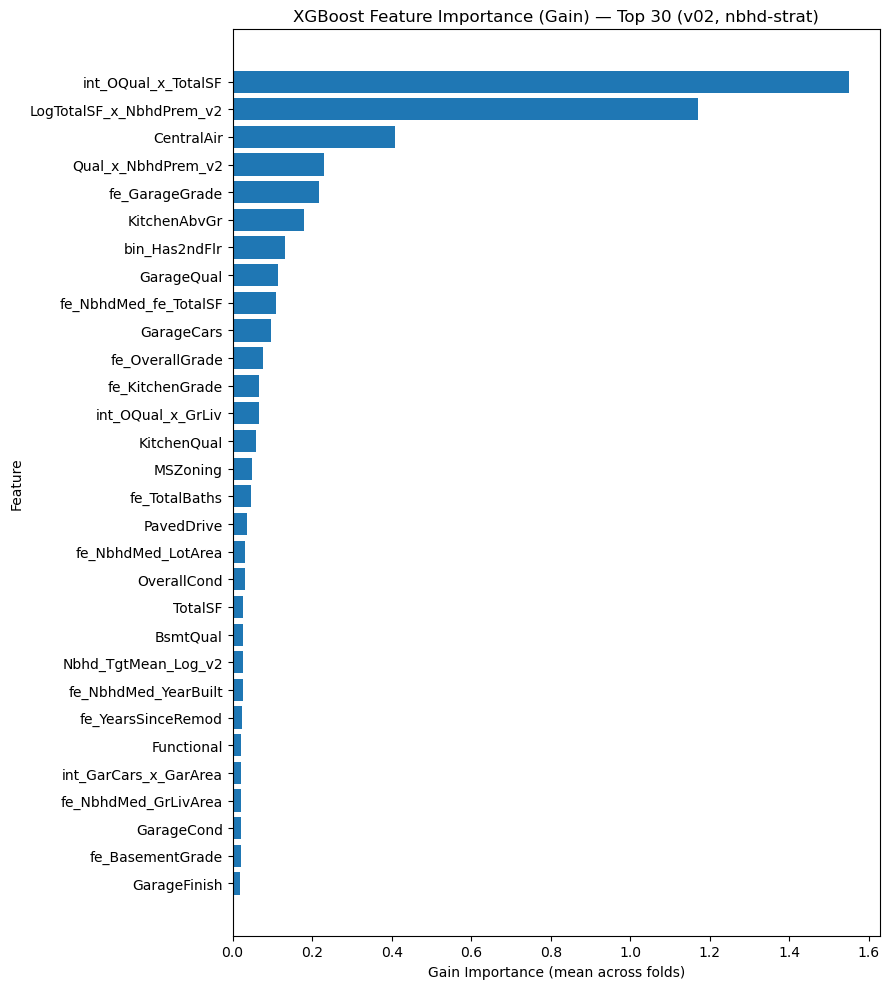

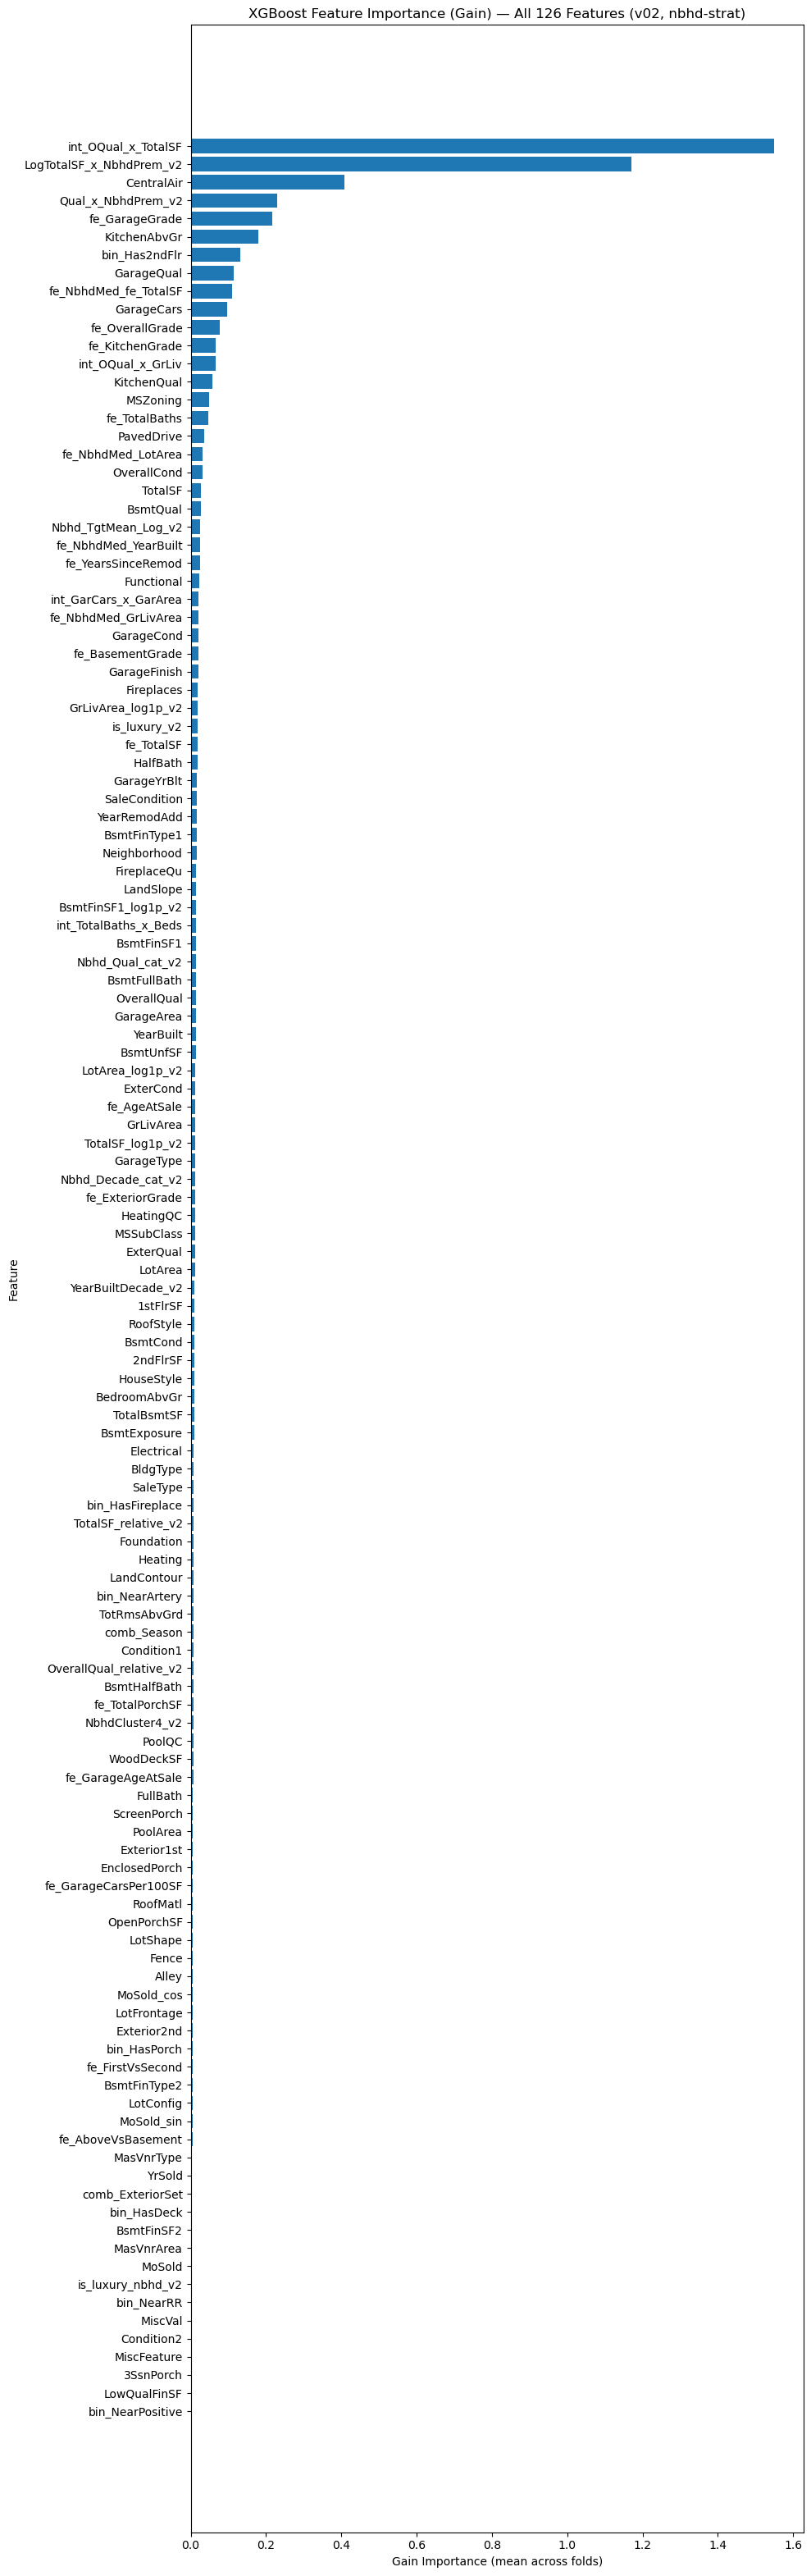

,saved
0,../artifacts/xgb_v02_baseline_nbhdstrat_feat_i...
1,../artifacts/xgb_v02_baseline_nbhdstrat_feat_i...


In [9]:
# E) Feature-importance plots (Top-30 gain + All gain) and log to MLflow if active
import matplotlib.pyplot as plt
import numpy as np

# Top-30 by gain
topk = 30
top_gain = gain_agg.head(topk).sort_values("gain", ascending=True)

fig1 = plt.figure(figsize=(9, 10))
plt.barh(top_gain["feature"], top_gain["gain"])
plt.xlabel("Gain Importance (mean across folds)")
plt.ylabel("Feature")
plt.title(f"XGBoost Feature Importance (Gain) — Top {topk} (v02, nbhd-strat)")
plt.tight_layout()
fig_top_path = ARTIFACTS_DIR / f"{run_tag}_feat_importance_gain_top{topk}.png"
plt.savefig(fig_top_path, dpi=200, bbox_inches="tight"); plt.show()

# All features by gain
nfeat = len(gain_agg)
height_in = float(np.clip(nfeat*0.25, 6.0, 60.0))
all_gain = gain_agg.sort_values("gain", ascending=True)

fig2 = plt.figure(figsize=(10, height_in))
plt.barh(all_gain["feature"], all_gain["gain"])
plt.xlabel("Gain Importance (mean across folds)")
plt.ylabel("Feature")
plt.title(f"XGBoost Feature Importance (Gain) — All {nfeat} Features (v02, nbhd-strat)")
plt.tight_layout()
fig_all_path = ARTIFACTS_DIR / f"{run_tag}_feat_importance_gain_all.png"
plt.savefig(fig_all_path, dpi=200, bbox_inches="tight"); plt.show()

if mlflow.active_run() is not None:
    mlflow.log_artifact(str(fig_top_path))
    mlflow.log_artifact(str(fig_all_path))

pd.DataFrame({"saved":[str(fig_top_path), str(fig_all_path)]})

In [11]:
# Ridge-like stack (ElasticNet with l1_ratio=0, positive weights) on LOG OOFs
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.linear_model import ElasticNetCV

DATA_DIR = Path("../data/")
PROCESSED_DIR = DATA_DIR / "processed"
ARTIFACTS_DIR = Path("../artifacts")
OOF_DIR = ARTIFACTS_DIR / "oof"
SUB_DIR = ARTIFACTS_DIR / "submissions"

# List the models we want in the stack (only those that exist will be used)
oof_candidates = {
    "lgbm_optuna_v01":            OOF_DIR / "lgbm_optuna_v01_oof.csv",
    "lgbm_v02_refit_prevbest":    OOF_DIR / "lgbm_v02_refit_prevbest_oof.csv",
    "xgb_v02_baseline_nbhdstrat": OOF_DIR / "xgb_v02_baseline_nbhdstrat_oof.csv",
    # optionally:
    # "lgbm_v02_optuna_stageA":   OOF_DIR / "lgbm_v02_optuna_stageA_oof.csv",
    # "elasticnet_baseline_v01":  OOF_DIR / "elasticnet_baseline_v01_oof.csv",
}

sub_candidates = {
    "lgbm_optuna_v01":            SUB_DIR / "lgbm_optuna_v01.csv",
    "lgbm_v02_refit_prevbest":    SUB_DIR / "lgbm_v02_refit_prevbest.csv",
    "xgb_v02_baseline_nbhdstrat": SUB_DIR / "xgb_v02_baseline_nbhdstrat.csv",
    # keep keys in sync with oof_candidates if you add more
}

# Load y (log) for CV scoring
df_tr = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v02.csv")
y_log = np.log1p(df_tr["SalePrice"]).values

# Build OOF design matrix (Id alignment)
usable = {k:p for k,p in oof_candidates.items() if p.exists()}
oof_parts = []
for name, path in usable.items():
    dfp = pd.read_csv(path).sort_values("Id")
    dfp = dfp.rename(columns={"pred_log": f"{name}"})
    oof_parts.append(dfp[["Id", f"{name}"]])

# inner join to ensure perfect alignment across models
oof_mat = oof_parts[0]
for dfp in oof_parts[1:]:
    oof_mat = oof_mat.merge(dfp, on="Id", how="inner")

X = oof_mat.drop(columns=["Id"]).to_numpy()
y = y_log[np.argsort(df_tr["Id"].values)[:len(oof_mat)]]  # align to Id sort

# Fit non-negative ridge-like stacker on LOG preds
stacker = ElasticNetCV(
    l1_ratio=0.0,                  # ridge
    alphas=np.logspace(-6, 2, 40),
    cv=5,
    positive=True,
    max_iter=20000,
)
stacker.fit(X, y)

weights = pd.Series(stacker.coef_, index=oof_mat.columns[1:])
intercept = float(stacker.intercept_)

pd.DataFrame({"weight": weights}).sort_values("weight", ascending=False).T

,xgb_v02_baseline_nbhdstrat,lgbm_v02_refit_prevbest,lgbm_optuna_v01
weight,0.348369,0.342018,0.319764


In [12]:
# Build blended submission from the same models (apply linear combo on LOG prices)
# Load test submissions, align Ids, transform to log, apply weights + intercept, expm1 back
subs = []
names_in_order = list(oof_mat.columns[1:])
for name in names_in_order:
    path = sub_candidates[name]
    dfp = pd.read_csv(path).sort_values("Id")
    subs.append(np.log1p(dfp["SalePrice"].values))

log_subs = np.vstack(subs).T  # shape (n_test, n_models)
log_stack = log_subs.dot(weights.values) + intercept
stack_prices = np.expm1(log_stack)

ids = pd.read_csv(list(sub_candidates.values())[0]).sort_values("Id")["Id"].values
stack_tag = "stack_enetpos_lgbm01_lgbm02_xgb_nbhdstrat"
stack_path = SUB_DIR / f"{stack_tag}.csv"
pd.DataFrame({"Id": ids, "SalePrice": stack_prices}).to_csv(stack_path, index=False)

pd.Series({"submission": str(stack_path), "n_models": len(names_in_order)})

submission    ../artifacts/submissions/stack_enetpos_lgbm01_...
n_models                                                      3
dtype: object

In [13]:
# (Optional) CV check of the stack on OOFs (sanity)
from sklearn.metrics import mean_squared_error

oof_pred_log = X.dot(weights.values) + intercept
rmse = float(np.sqrt(mean_squared_error(y, oof_pred_log)))
pd.Series({"cv_rmse_mean_log_stack": rmse})

cv_rmse_mean_log_stack    0.117923
dtype: float64

In [14]:
# Inspect OOF correlations and build better stack (all nbhdstrat models, LOG domain)
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

PROCESSED_DIR = Path("../data/processed")
ART_DIR = Path("../artifacts"); OOF_DIR = ART_DIR / "oof"; SUB_DIR = ART_DIR / "submissions"

# load OOFs (must be from the SAME fold scheme)
oofs = {
    "lgbm": OOF_DIR / "lgbm_v02_baseline_nbhdstrat_oof.csv",
    "xgb" : OOF_DIR / "xgb_v02_baseline_nbhdstrat_oof.csv",
    "cat" : OOF_DIR / "cat_v02_baseline_nbhdstrat_oof.csv",
}
parts=[]; names=[]
for name, p in oofs.items():
    if p.exists():
        df = pd.read_csv(p).rename(columns={"pred_log": name})
        parts.append(df[["Id", name]]); names.append(name)
oof_mat = parts[0]
for df in parts[1:]:
    oof_mat = oof_mat.merge(df, on="Id", how="inner")

# y aligned by Id
y_df = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v02.csv", usecols=["Id","SalePrice"])
y_df["y_log"] = np.log1p(y_df["SalePrice"])
oof_mat = oof_mat.merge(y_df, on="Id", how="left")
X = oof_mat[names].to_numpy()
y = oof_mat["y_log"].to_numpy()

# 1) Correlation (helpful to see redundancy)
corr = pd.DataFrame(X, columns=names).corr().round(3)

# 2) Ridge stacker (non-negative), with and without intercept
def fit_stack(X, y, fit_intercept):
    model = ElasticNetCV(l1_ratio=0.0, alphas=np.logspace(-6,2,40),
                         cv=5, positive=True, fit_intercept=fit_intercept, max_iter=20000)
    model.fit(X, y)
    pred = model.predict(X)
    rmse = float(np.sqrt(mean_squared_error(y, pred)))
    return model, rmse

ridge_wi, rmse_wi = fit_stack(X, y, fit_intercept=True)
ridge_ni, rmse_ni = fit_stack(X, y, fit_intercept=False)

# 3) Fine convex grid (weights sum=1, >=0) around Cat dominance
grid = np.linspace(0.0, 1.0, 101)
best = (None, 1e9)
for wl in grid:          # weight for lgbm
    for wx in grid:      # weight for xgb
        wc = 1.0 - wl - wx
        if wc < 0: 
            continue
        W = np.array([wl, wx, wc])[:len(names)]
        rmse = float(np.sqrt(mean_squared_error(y, X.dot(W))))
        if rmse < best[1]:
            best = (W.copy(), rmse)
W_conv, rmse_conv = best

# pick the best strategy
modes = pd.DataFrame({
    "mode": ["ridge_intercept","ridge_no_intercept","convex_sum1"],
    "rmse_log": [rmse_wi, rmse_ni, rmse_conv]
}).sort_values("rmse_log")

weights = {
    "ridge_intercept": (ridge_wi.coef_, float(getattr(ridge_wi, "intercept_", 0.0))),
    "ridge_no_intercept": (ridge_ni.coef_, 0.0),
    "convex_sum1": (W_conv, 0.0),
}
best_mode = modes.iloc[0]["mode"]
coef, intercept = weights[best_mode]
pd.DataFrame({"model": names, "weight": coef}).assign(intercept=intercept), corr, modes

(  model    weight  intercept
 0  lgbm  0.191875  -0.316727
 1   xgb  0.186999  -0.316727
 2   cat  0.647251  -0.316727,
        lgbm    xgb    cat
 lgbm  1.000  0.992  0.991
 xgb   0.992  1.000  0.990
 cat   0.991  0.990  1.000,
                  mode  rmse_log
 0     ridge_intercept  0.114988
 2         convex_sum1  0.115440
 1  ridge_no_intercept  0.121496)

In [15]:
# Build submission for the chosen stacker (LOG domain → expm1)
subs = []
for name in names:
    dfp = pd.read_csv(SUB_DIR / f"{name}_v02_baseline_nbhdstrat.csv").sort_values("Id")  # adjust if your filenames differ
    dfp["logp"] = np.log1p(dfp["SalePrice"])
    subs.append(dfp[["Id","logp"]].rename(columns={"logp": f"logp_{name}"}))

sub_mat = subs[0]
for df in subs[1:]:
    sub_mat = sub_mat.merge(df, on="Id", how="inner")

import numpy as np, pandas as pd
logX = sub_mat[[f"logp_{n}" for n in names]].to_numpy()
log_blend = logX.dot(coef[:len(names)]) + intercept
out = pd.DataFrame({"Id": sub_mat["Id"], "SalePrice": np.expm1(log_blend)})

tag = f"stack_{best_mode}_nbhdstrat_lgbm_xgb_cat"
path = SUB_DIR / f"{tag}.csv"
out.to_csv(path, index=False)

pd.Series({"submission": str(path), "mode": best_mode, "weights": list(zip(names, coef[:len(names)])), "intercept": intercept})

submission    ../artifacts/submissions/stack_ridge_intercept...
mode                                            ridge_intercept
weights       [(lgbm, 0.19187531469928118), (xgb, 0.18699876...
intercept                                             -0.316727
dtype: object

In [16]:
# 3-seed CatBoost average (same folds), OOF on LOG + test mean
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
import numpy as np, pandas as pd
from pathlib import Path

DATA_DIR = Path("../data/"); PROCESSED_DIR = DATA_DIR / "processed"
ART_DIR = Path("../artifacts"); OOF_DIR = ART_DIR / "oof"; SUB_DIR = ART_DIR / "submissions"

# Reload features to ensure clean dtypes
df_tr = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v02.csv")
df_te = pd.read_csv(PROCESSED_DIR / "hp_test_feat_v02.csv")
folds_df = pd.read_csv(PROCESSED_DIR / "cv_folds_strat_nbhd_price_v01.csv")
df_tr = df_tr.merge(folds_df, on="Id", how="left")

# cat list: reuse what you used before (names, not indices)
# If you saved it in meta:
with open(PROCESSED_DIR / "hp_clean_meta_v03.json","r") as f:
    meta = json.load(f)
nominal_cols = set(meta.get("nominal_cols_final", [])) | set(meta.get("engineered_nominal", [])) \
               | {"Nbhd_Qual_cat_v2","Nbhd_Decade_cat_v2","NbhdCluster4_v2"}
cat_features = [c for c in nominal_cols if c in df_tr.columns]

X = df_tr.drop(columns=["SalePrice","fold"])
T = df_te[X.columns]
y_log = np.log1p(df_tr["SalePrice"]).astype(float).values
fold = df_tr["fold"].values

# CatBoost requires string/int cats with no NaN
def to_cat_strings(df, cols, token="Missing"):
    for c in cols:
        df[c] = df[c].astype("object").where(df[c].notna(), token).astype(str)
    return df
X = to_cat_strings(X, cat_features); T = to_cat_strings(T, cat_features)

cb_params = dict(
    loss_function="RMSE", iterations=20000, learning_rate=0.03, depth=8, l2_leaf_reg=3.0,
    subsample=0.8, random_seed=0, eval_metric="RMSE", od_type="Iter", od_wait=200,
    allow_writing_files=False, verbose=False
)

seeds = [42, 77, 123]
oof_seeds = np.full((len(df_tr), len(seeds)), np.nan)
test_seeds = []

for s_i, seed in enumerate(seeds):
    params = cb_params.copy(); params["random_seed"] = seed
    oof_tmp = np.zeros(len(df_tr)); test_folds=[]
    for k in sorted(np.unique(fold)):
        tr_idx = np.where(fold != k)[0]; va_idx = np.where(fold == k)[0]
        train_pool = Pool(X.iloc[tr_idx], label=y_log[tr_idx], cat_features=cat_features)
        valid_pool = Pool(X.iloc[va_idx], label=y_log[va_idx], cat_features=cat_features)
        test_pool  = Pool(T, cat_features=cat_features)

        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

        oof_tmp[va_idx] = model.predict(valid_pool)
        test_folds.append(model.predict(test_pool))
    oof_seeds[:, s_i] = oof_tmp
    test_seeds.append(np.column_stack(test_folds).mean(axis=1))

oof_mean = np.nanmean(oof_seeds, axis=1)
test_mean = np.column_stack(test_seeds).mean(axis=1)

# CV on OOF mean
cv_scores=[]
for k in sorted(np.unique(fold)):
    va_idx = np.where(fold == k)[0]
    cv_scores.append(float(np.sqrt(mean_squared_error(y_log[va_idx], oof_mean[va_idx]))))

run_tag = "cat_v02_seedavg3_nbhdstrat"
pd.DataFrame({"Id": df_tr["Id"], "pred_log": oof_mean}).to_csv(OOF_DIR / f"{run_tag}_oof.csv", index=False)
pd.DataFrame({"Id": df_te["Id"], "SalePrice": np.expm1(test_mean)}).to_csv(SUB_DIR / f"{run_tag}.csv", index=False)

pd.DataFrame({"fold": sorted(np.unique(fold)), "rmse": cv_scores}).assign(
    cv_mean=float(np.mean(cv_scores)), cv_std=float(np.std(cv_scores))
)

,fold,rmse,cv_mean,cv_std
0,0,0.107518,0.115474,0.009199
1,1,0.109560,0.115474,0.009199
2,2,0.132255,0.115474,0.009199
3,3,0.118433,0.115474,0.009199
4,4,0.109603,0.115474,0.009199
